<a href="https://colab.research.google.com/github/MuraliManobhiRam/CSCE5218DEEPLEARNING/blob/main/Deep_Learning_Project_Group__15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Instructions to Run the Notebook

1.  **Open the Notebook:** Open this notebook in Google Colab.
2.  **Runtime:** Select "Runtime" -> "Run all" to execute all cells.
3.  **Observe Outputs:** The output of each cell, including model training and evaluation results, will be displayed below the cell.

## Code Description

The notebook performs image classification on the "Fruit and Vegetable Diseases Dataset". Here's a breakdown:

### 1.  Import Libraries

    * Imports necessary libraries, including TensorFlow, Keras, and others, for data loading, model definition, training, and evaluation. And install the libraries if it is not present

### 2.  Load the Dataset

    * Downloads the dataset from Kaggle using `kagglehub`.
    * Prints the path to the dataset.

### 3.  Exploratory Data Analysis

    * Calculates and prints the number of classes and the distribution of images across classes.
    * Visualizes the class distribution using a bar plot.
    * Retreiving the random image from every class

### 4.  Data Augmentation

    * Defines image size and batch size.
    * Creates training and testing datasets using `image_dataset_from_directory`.
    * Applies data augmentation to the training set, including random flips and rotations.
    * Prefetches data for improved performance.

### 5.  Define Models

    * **Baseline Model:** A simple convolutional neural network (CNN) with a few layers.
    * **Custom Model:** A more complex model using EfficientNetV2B0 as the base, with added layers for fine-tuning.

### 6.  Train Models

    * Trains both the baseline model and the custom model on the training data.
    * Uses `ReduceLROnPlateau` to adjust the learning rate during training.
    * Saves the trained model weights.

### 7.  Evaluate Models

    * Evaluates the trained models on the test dataset.
    * Prints the test accuracy for both models.
    * Generates and prints a classification report.
    * Plots the confusion matrix for the custom model.

### 8.  Display Results

    * The results, including test accuracy, classification report, and confusion matrix, are displayed in the notebook.

    * Finally run the fruit classification model and it prompts for the input and give the image regarding to fruit and output will be printed


# Data Preprocessing

In [19]:
# @title Importing Required Libraries
#In this task we are performing EDA,these are the required libraries to perform EDA.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
import kagglehub
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [20]:
# @title Loading the Dataset
# Here i provided the dataset path from kaggle to download the data
dataset_path = kagglehub.dataset_download("muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten")
print("Path for the dataset files:", dataset_path)
# Here we are printing the data directory path
data_dir = os.path.join(dataset_path, os.listdir(dataset_path)[0])
print(f"Data directory: {data_dir}")

Path for the dataset files: /kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten
Data directory: /kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset


In [197]:
# @title Exploratory Data Analysis
# Here we are performing the eda on the fruits and vegetables dataset
class_labels = sorted(os.listdir(data_dir))
num_classes = len(class_labels)
class_distribution = [len(os.listdir(os.path.join(data_dir, i))) for i in class_labels]
# Based on the above performed eda here we are printing the total no of classes and the labels for class and per class image distribution
print(f"Total Number of Classes : {num_classes} \nClass Names : {class_labels} \nClass Distribution: {class_distribution}")

Total Number of Classes : 28 
Class Names : ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten'] 
Class Distribution: [2438, 2930, 2000, 2800, 611, 591, 620, 580, 608, 593, 200, 200, 200, 200, 200, 200, 1813, 2247, 2075, 2186, 200, 200, 615, 585, 1603, 1596, 604, 596]


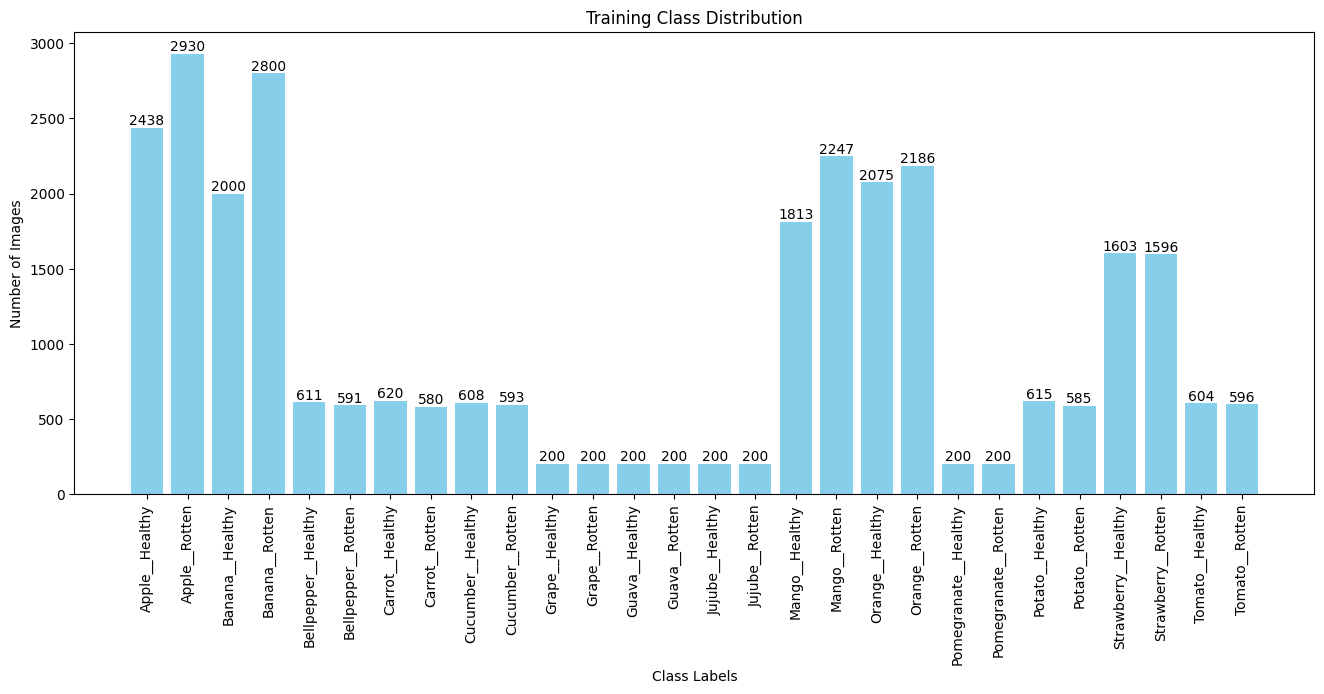

In [223]:
import matplotlib.pyplot as plt

# Here we are Creating the bar plot for class distribution
plt.figure(figsize=(16, 6))
bars = plt.bar(class_labels, class_distribution, color='skyblue')

# Here we are Adding title and labels
plt.title("Training Class Distribution")
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=90)

# Here we are Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(int(yval)), ha='center', va='bottom')

#Here we are Displaying the bar plot
plt.show()


In [23]:
# From the dataset we are retreiving the total no of images
img_total = 0
for class_label in class_labels:
    img_total += len(os.listdir(os.path.join(data_dir, class_label)))

print(f"Total no of images: {img_total}")


Total no of images: 29291


In [24]:
# Here we are intiallizing the lists to store the information
fruits_and_veggies = []
num_total, num_rotten, num_healthy = [], [], []

# Here we are iterating over the subdirectories
for sub_dir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        fruit = sub_dir.split('__')[0]
        if fruit not in fruits_and_veggies:
            fruits_and_veggies.append(fruit)

# Here we are counting the total, healthy, and rotten images for every fruit
for fruit in fruits_and_veggies:
    total = rotten = healthy = 0
    for sub_dir in os.listdir(data_dir):
        sub_dir_path = os.path.join(data_dir, sub_dir)
        if os.path.isdir(sub_dir_path) and fruit in sub_dir:
            count = len(os.listdir(sub_dir_path))
            total += count
            if "__Rotten" in sub_dir:
                rotten += count
            elif "__Healthy" in sub_dir:
                healthy += count
    num_total.append(total)
    num_rotten.append(rotten)
    num_healthy.append(healthy)

# Here we created the dictionary and converted into dataframe
fruits_and_veggies_dict = {
    "fruits": fruits_and_veggies,
    "total": num_total,
    "rotten": num_rotten,
    "healthy": num_healthy
}
fruits_and_veggies_df = pd.DataFrame(fruits_and_veggies_dict).sort_values(by="total")

# Here we are displaying the dataframe
print(fruits_and_veggies_df)


         fruits  total  rotten  healthy
1         Grape    400     200      200
2         Guava    400     200      200
7        Jujube    400     200      200
5   Pomegranate    400     200      200
4        Tomato   1200     596      604
6        Potato   1200     585      615
12       Carrot   1200     580      620
13     Cucumber   1201     593      608
11   Bellpepper   1202     591      611
0    Strawberry   3199    1596     1603
10        Mango   4060    2247     1813
3        Orange   4261    2186     2075
9        Banana   4800    2800     2000
8         Apple   5368    2930     2438


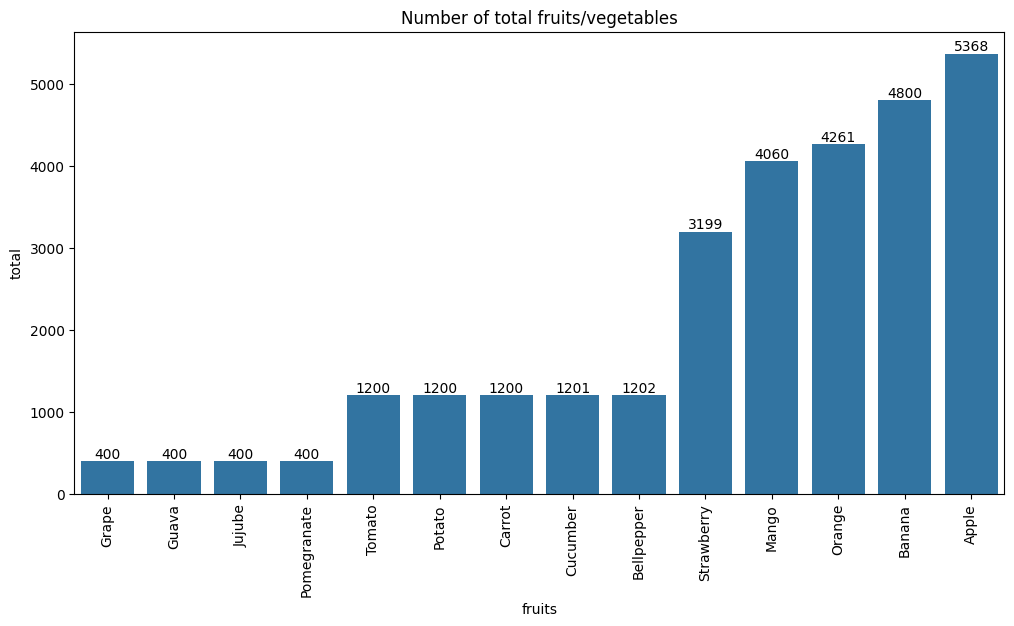

In [25]:
# Here we are utilizing the bar plot to visuallize the no of totsl fruits or vegetables in the dataset
plt.figure(figsize=(12, 6))
plt.title("Number of total fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='total')
ax.bar_label(ax.containers[0], fontsize=10);

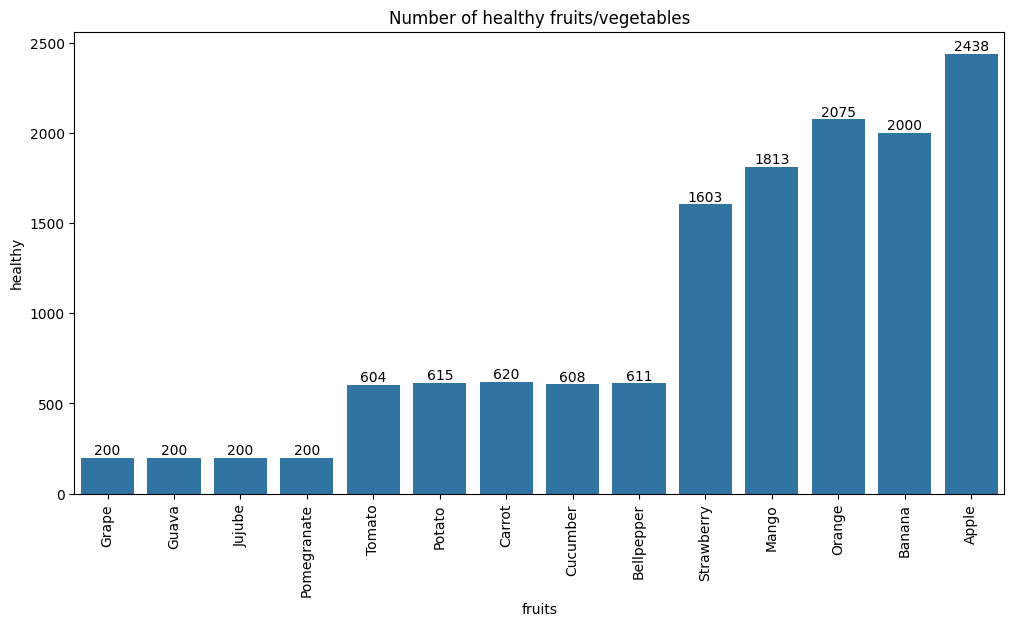

In [26]:
# Here we are utilizing the bar plot to visuallize the no of totsl fruits or vegetables in the dataset
plt.figure(figsize=(12, 6))
plt.title("Number of healthy fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='healthy')
ax.bar_label(ax.containers[0], fontsize=10);

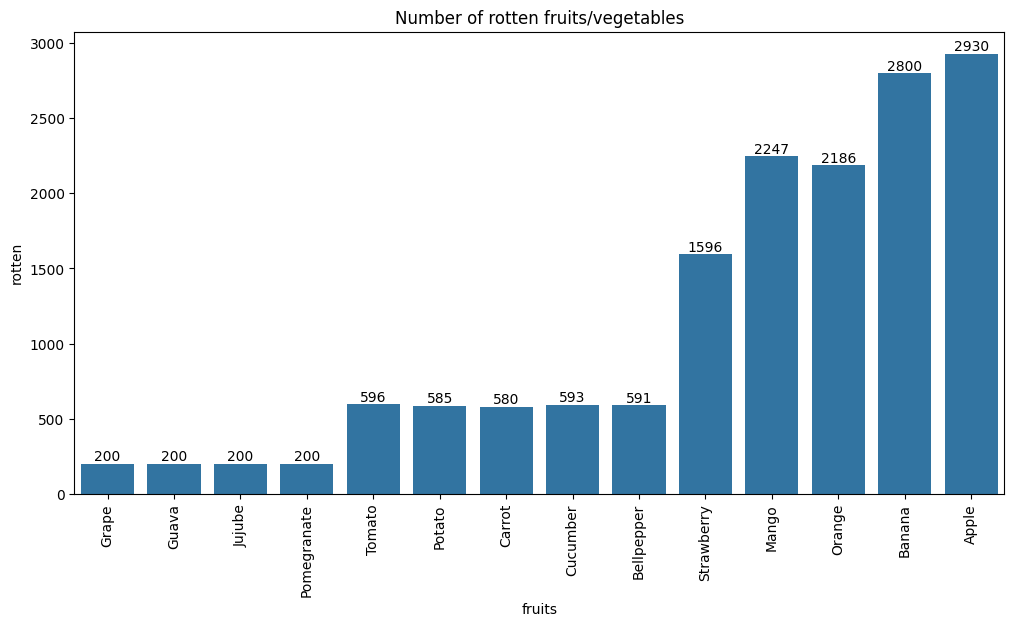

In [27]:
# Here we are utilizing the bar plot to visuallize the no of totsl fruits or vegetables in the dataset
plt.figure(figsize=(12, 6))
plt.title("Number of rotten fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='rotten')
ax.bar_label(ax.containers[0], fontsize=10);

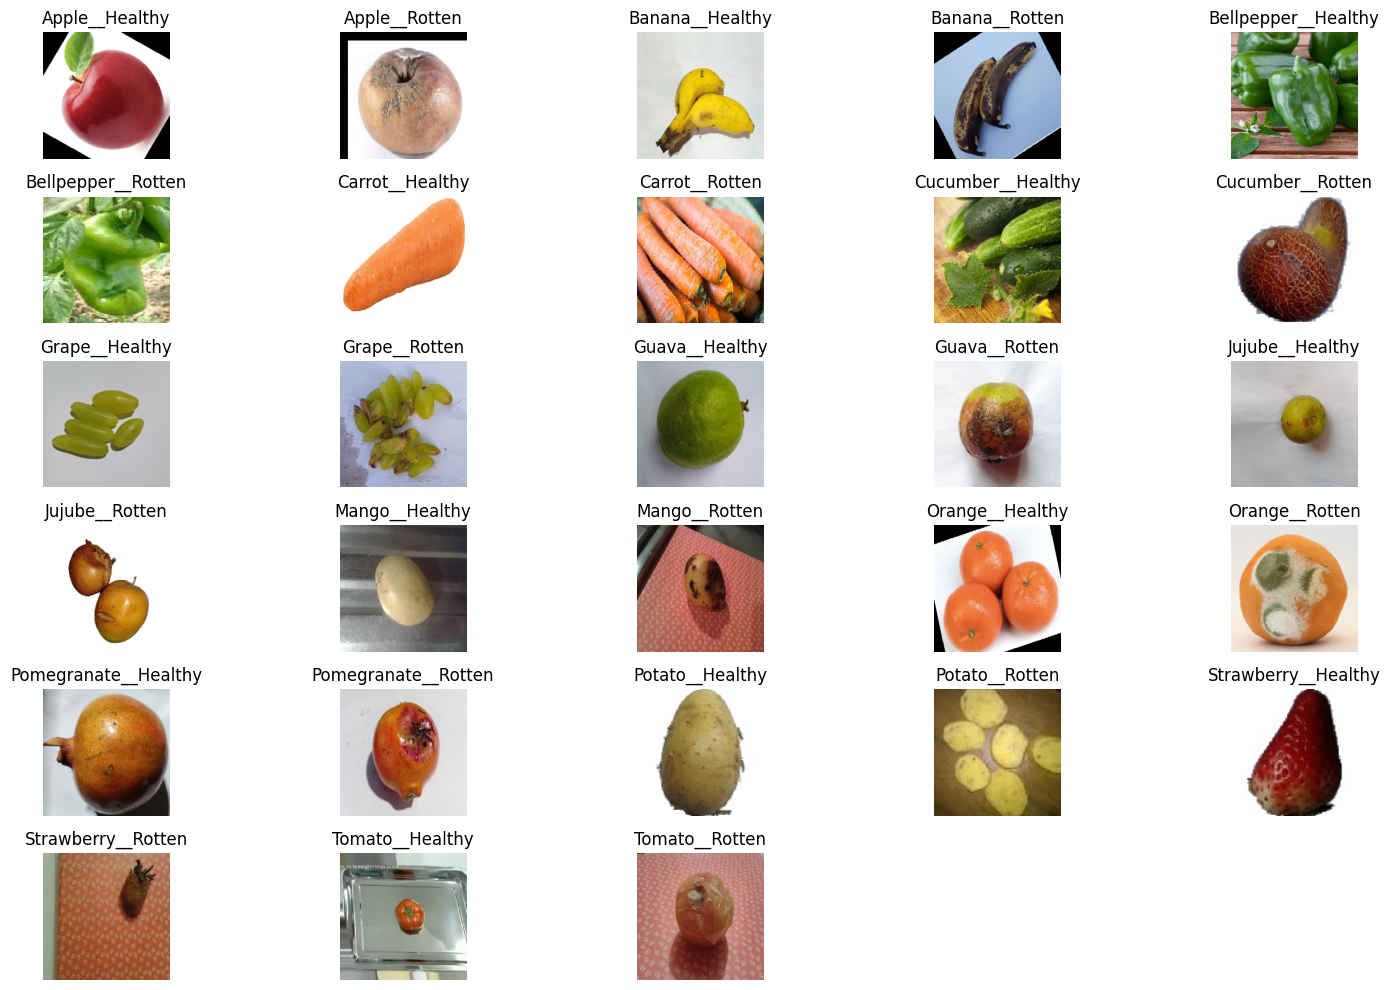

In [28]:
# Here we are retreiving the random image from every class
plt.figure(figsize=(15, 10))


for i, name_of_class in enumerate(class_labels):
    class_path = os.path.join(data_dir, name_of_class)

    # Here this is the code to select the random image from every class
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    # Here we are loading the image and performing normalization
    img = load_img(img_path, target_size=(224, 224))
    array_img = img_to_array(img) / 255.0
    rows = (len(class_labels) // 5) + (1 if len(class_labels) % 5 != 0 else 0)

    # Here we are displaying the image
    plt.subplot(rows, 5, i + 1)
    plt.imshow(array_img)
    plt.axis("off")
    plt.title(name_of_class)

plt.tight_layout()
plt.show()


# Training, Validation, Testing Split For The Data

In [29]:
# Training, Validation, Testing Split For The Data
import shutil
import os
import random

# Here we are defining the path for the dataset
dataset_path = '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset'
output_path = '/kaggle/working/fruit-and-vegetable-disease'

# Here we are only choosing the directories which represents the classes
class_labels = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])

# Here we are defining the path for the directories of train, valid, test
train_dir = os.path.join(output_path, 'train')
valid_dir = os.path.join(output_path, 'valid')
test_dir = os.path.join(output_path, 'test')

# Here we are Creating the directories for train, valid, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Here we are creating the subdirectories for train, valid, and test
for class_label in class_labels:
    os.makedirs(os.path.join(train_dir, class_label), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_label), exist_ok=True)

# Here we are Splitting the images into train, valid, and test sets
test_percentage = 0.1

for class_label in class_labels:
    class_path = os.path.join(dataset_path, class_label)
    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
    random.shuffle(images)

    # Here we are Calculating the no of test images
    num_test = int(len(images) * test_percentage)
    test_images = images[:num_test]
    remaining_images = images[num_test:]

    # Here we are splitting the remaining images into train and validation sets which is 80 and 20
    num_valid = int(len(remaining_images) * 0.2)
    valid_images = remaining_images[:num_valid]
    train_images = remaining_images[num_valid:]

    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_label, img)
        shutil.copy2(src, dst)

    for img in valid_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(valid_dir, class_label, img)
        shutil.copy2(src, dst)

    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_label, img)
        shutil.copy2(src, dst)

print("Dataset has been successfully split into train, valid, and test directories.")

# This is the code to Check the no of images in each directory
for class_label in class_labels:
    class_train_images_count = len(os.listdir(os.path.join(train_dir, class_label)))
    class_valid_images_count = len(os.listdir(os.path.join(valid_dir, class_label)))
    class_test_images_count = len(os.listdir(os.path.join(test_dir, class_label)))
    print(f"Class '{class_label}' - Train: {class_train_images_count}, Valid: {class_valid_images_count}, Test: {class_test_images_count}")

Removed existing directory: /kaggle/working/fruit-and-vegetable-disease
Dataset copied to writable location! ✅
No wrong folder found. Nothing to fix.
Dataset has been successfully split into train, valid, and test directories.
Class 'Apple__Healthy' - Train: 1756, Valid: 439, Test: 243
Class 'Apple__Rotten' - Train: 2110, Valid: 527, Test: 293
Class 'Banana__Healthy' - Train: 1440, Valid: 360, Test: 200
Class 'Banana__Rotten' - Train: 2016, Valid: 504, Test: 280
Class 'Bellpepper__Healthy' - Train: 440, Valid: 110, Test: 61
Class 'Bellpepper__Rotten' - Train: 426, Valid: 106, Test: 59
Class 'Carrot__Healthy' - Train: 447, Valid: 111, Test: 62
Class 'Carrot__Rotten' - Train: 418, Valid: 104, Test: 58
Class 'Cucumber__Healthy' - Train: 439, Valid: 109, Test: 60
Class 'Cucumber__Rotten' - Train: 428, Valid: 106, Test: 59
Class 'Grape__Healthy' - Train: 144, Valid: 36, Test: 20
Class 'Grape__Rotten' - Train: 144, Valid: 36, Test: 20
Class 'Guava__Healthy' - Train: 144, Valid: 36, Test: 20


# Data Augmentation

In [30]:
# Here we are intiallizing the image data generator for data augmentation during the training process
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

In [31]:
# Here we are defining the batch size for the training
batch_size = 32
# For the input image we are defining the target image
img_size = (224, 224)

In [32]:
#utilizes the training directory for generating batches of augmented image data.
train_data = train_datagenerator.flow_from_directory(
    train_dir,# This is the path to the train folder
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="training",
    seed=42
)

Found 21093 images belonging to 28 classes.


In [33]:
# utilizes the validation directory for generating batches of augmented image data.
valid_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_dir,  # This is the path to the valid folder
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 5263 images belonging to 28 classes.


In [34]:
# Displays how class names are mapped to their number labels.
print(f"Classes: {train_data.class_indices}")
# Shows how many samples are in the validation and training sets.
print(f"Train samples: {train_data.samples}, Valid samples: {valid_data.samples}")

Classes: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
Train samples: 21093, Valid samples: 5263


In [35]:
# utilizes the tesing directory for generating batches of augmented image data.
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True, # We are not shuffling for the test set
    seed=42
)

Found 2921 images belonging to 28 classes.


# Baseline Model

In [54]:
# @title Defining Baseline Model And Training The Baseline Model
#A baseline Convolutional Neural Network model is defined and trained using the Keras Sequential API in that we are passing convolution layer with different filters
baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(28, activation='softmax')
])
# Here we are compiling the model with the parameters
baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Here we are printing the summary
print("\n--- Baseline Model Summary ---")
baseline_model.summary()

# Here we are training the baseline model with epochs as 10 and here we are utilizing the fit function in that we are passing the train and validation data
epochs_baseline = 5
history_baseline = baseline_model.fit(
    train_data,
    epochs=epochs_baseline,
    validation_data=valid_data,
)


--- Baseline Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 28)             │     2,422,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,516,060 (9.60 MB)

 Trainable params: 2,516,060 (9.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
 70/660 ━━━━━━━━━━━━━━━━━━━━ 5:29 559ms/step - accuracy: 0.1182 - loss: 3.0849

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



660/660 ━━━━━━━━━━━━━━━━━━━━ 409s 613ms/step - accuracy: 0.3284 - loss: 2.2521 - val_accuracy: 0.6418 - val_loss: 1.2660
Epoch 2/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 400s 606ms/step - accuracy: 0.6008 - loss: 1.3177 - val_accuracy: 0.7344 - val_loss: 0.9422
Epoch 3/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 401s 608ms/step - accuracy: 0.6794 - loss: 1.0622 - val_accuracy: 0.7750 - val_loss: 0.7863
Epoch 4/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 403s 610ms/step - accuracy: 0.7064 - loss: 0.9579 - val_accuracy: 0.7851 - val_loss: 0.7725
Epoch 5/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 400s 607ms/step - accuracy: 0.7467 - loss: 0.8427 - val_accuracy: 0.7938 - val_loss: 0.7128


In [171]:
# Here we are computing the class weights based on the strategy which iis balanced
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
train_class_weights = dict(zip(np.unique(train_data.classes), class_weights))
print("Class Weights:", train_class_weights)


Class Weights: {np.int32(0): np.float64(0.428998535632932), np.int32(1): np.float64(0.35736310653293574), np.int32(2): np.float64(0.5235034249975181), np.int32(3): np.float64(0.37422823078560785), np.int32(4): np.float64(1.7120941558441558), np.int32(5): np.float64(1.7683601609657948), np.int32(6): np.float64(1.6890614990390775), np.int32(7): np.float64(1.8065262076053443), np.int32(8): np.float64(1.715994142531728), np.int32(9): np.float64(1.7600967957276368), np.int32(10): np.float64(5.231398809523809), np.int32(11): np.float64(5.231398809523809), np.int32(12): np.float64(5.231398809523809), np.int32(13): np.float64(5.231398809523809), np.int32(14): np.float64(5.231398809523809), np.int32(15): np.float64(5.231398809523809), np.int32(16): np.float64(0.5768157952308028), np.int32(17): np.float64(0.46530045001323567), np.int32(18): np.float64(0.5038939321548017), np.int32(19): np.float64(0.47829931972789114), np.int32(20): np.float64(5.231398809523809), np.int32(21): np.float64(5.231398

# Defining Model As EfficientNetV2B0 And Training The Model

In [43]:
# @title Defining Model As EfficientNetV2B0 And Training The Model
# After pre-training the EfficientNetV2B0 model on ImageNet, load it without the top classification layer for fine tuning
main_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True)

In [44]:
from tensorflow.keras.regularizers import l2
# Here we are choosing the model EfficientNetV2B0 with pre-trained weights
main_model.trainable = False  # Here we are freezing the efficient layers

# Here we are providing the model input
inputs = layers.Input(shape=(224, 224, 3))
# Utlizing the EfficientNetV2B0 model
x = main_model(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(28, activation='softmax')(x)

# Here we are building the model
model_efficientnet = models.Model(inputs, outputs)


# Here we are choosing the AdamW optimizer with learning rate which is adjustable
optimizer = optimizers.AdamW(learning_rate=1e-3)

# Here we are compiling the model with the parameters
model_efficientnet.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']
)

# Displaying the summary of the model
model_efficientnet.summary()
print("Class Weights:", train_class_weights)

Class Weights: {np.int32(0): np.float64(0.428998535632932), np.int32(1): np.float64(0.35736310653293574), np.int32(2): np.float64(0.5235034249975181), np.int32(3): np.float64(0.37422823078560785), np.int32(4): np.float64(1.7120941558441558), np.int32(5): np.float64(1.7683601609657948), np.int32(6): np.float64(1.6890614990390775), np.int32(7): np.float64(1.8065262076053443), np.int32(8): np.float64(1.715994142531728), np.int32(9): np.float64(1.7600967957276368), np.int32(10): np.float64(5.231398809523809), np.int32(11): np.float64(5.231398809523809), np.int32(12): np.float64(5.231398809523809), np.int32(13): np.float64(5.231398809523809), np.int32(14): np.float64(5.231398809523809), np.int32(15): np.float64(5.231398809523809), np.int32(16): np.float64(0.5768157952308028), np.int32(17): np.float64(0.46530045001323567), np.int32(18): np.float64(0.5038939321548017), np.int32(19): np.float64(0.47829931972789114), np.int32(20): np.float64(5.231398809523809), np.int32(21): np.float64(5.231398

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,255,468 (23.86 MB)

 Trainable params: 335,644 (1.28 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

Class Weights: {np.int32(0): np.float64(0.428998535632932), np.int32(1): np.float64(0.35736310653293574), np.int32(2): np.float64(0.5235034249975181), np.int32(3): np.float64(0.37422823078560785), np.int32(4): np.float64(1.7120941558441558), np.int32(5): np.float64(1.7683601609657948), np.int32(6): np.float64(1.6890614990390775), np.int32(7): np.float64(1.8065262076053443), np.int32(8): np.float64(1.715994142531728), np.int32(9): np.float64(1.7600967957276368), np.int32(10): np.float64(5.231398809523809), np.int32(11): np.float64(5.231398809523809), np.int32(12): np.float64(5.231398809523809), np.int32(13): np.float64(5.231398809523809), np.int32(14): np.float64(5.231398809523809), np.int32(15): np.float64(5.231398809523809), np.int32(16): np.float64(0.5768157952308028), np.int32(17): np.float64(0.46530045001323567), np.int32(18): np.float64(0.5038939321548017), np.int32(19): np.float64(0.47829931972789114), np.int32(20): np.float64(5.231398809523809), np.int32(21): np.float64(5.231398

In [45]:
# Here we are importing the EarlyStopping and ReduceLROnPlateau from Keras callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True)

In [46]:
# @title Pre-Fine-Tuning Training for The Model EfficientNetV2B0
# Here we are training the model with epochs as 5 and here we are utilizing the fit function in that we are passing the train and validation data
efficientnet_train = model_efficientnet.fit(
    train_data,
    epochs=5,
    validation_data=valid_data,
    class_weight=train_class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/5
155/660 ━━━━━━━━━━━━━━━━━━━━ 4:39 554ms/step - accuracy: 0.0349 - loss: 4.1648

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



660/660 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.0320 - loss: 3.9988

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



660/660 ━━━━━━━━━━━━━━━━━━━━ 454s 653ms/step - accuracy: 0.0320 - loss: 3.9986 - val_accuracy: 0.0657 - val_loss: 3.4596 - learning_rate: 0.0010
Epoch 2/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 399s 604ms/step - accuracy: 0.0311 - loss: 3.6067 - val_accuracy: 0.0730 - val_loss: 3.3448 - learning_rate: 0.0010
Epoch 3/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 397s 602ms/step - accuracy: 0.0362 - loss: 3.5073 - val_accuracy: 0.0266 - val_loss: 3.5250 - learning_rate: 0.0010
Epoch 4/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 399s 604ms/step - accuracy: 0.0342 - loss: 3.5293 - val_accuracy: 0.0192 - val_loss: 3.4033 - learning_rate: 0.0010
Epoch 5/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.0375 - loss: 3.4798
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
660/660 ━━━━━━━━━━━━━━━━━━━━ 404s 612ms/step - accuracy: 0.0375 - loss: 3.4799 - val_accuracy: 0.1157 - val_loss: 3.4297 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [47]:
# @title Fine-Tuning EfficientNetV2B0 for Enhanced Accuracy
# Here we are unfreezing the EfficientNet Layers for the purpose of Fine-Tuning
main_model.trainable = True

# Here we are reducing the Learning Rate to perform Fine-Tuning
optimizer = optimizers.AdamW(learning_rate=1e-4)

# Here we recompiling the Model with Learning Rate which is lower
model_efficientnet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Here we are training the model with epochs as 5 and here we are utilizing the fit function in that we are passing the train and validation data
model_efficientnet.fit(train_data, validation_data=valid_data, epochs=5, class_weight=train_class_weights,callbacks=[reduce_lr, early_stopping])

Epoch 1/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 531s 674ms/step - accuracy: 0.3892 - loss: 2.2688 - val_accuracy: 0.7990 - val_loss: 0.9292 - learning_rate: 1.0000e-04
Epoch 2/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 413s 625ms/step - accuracy: 0.8240 - loss: 0.7407 - val_accuracy: 0.8128 - val_loss: 0.7872 - learning_rate: 1.0000e-04
Epoch 3/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 400s 607ms/step - accuracy: 0.8966 - loss: 0.4780 - val_accuracy: 0.8744 - val_loss: 0.5737 - learning_rate: 1.0000e-04
Epoch 4/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 401s 608ms/step - accuracy: 0.9227 - loss: 0.3834 - val_accuracy: 0.4779 - val_loss: 2.0270 - learning_rate: 1.0000e-04
Epoch 5/5
660/660 ━━━━━━━━━━━━━━━━━━━━ 400s 607ms/step - accuracy: 0.9359 - loss: 0.3152 - val_accuracy: 0.3283 - val_loss: 2.8148 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.


# Evaluating Baseline Model On Test Data And Displaying Results For Baseline Model

In [83]:
# @title Evaluating Baseline Model On Test Data
# Here we are evaluating the baseline model on the dataset which is test and printing the accuracy and loss
print("\n--- Evaluating Baseline Model ---")
loss_baseline, accuracy_baseline = baseline_model.evaluate(test_data)
print(f"Test Accuracy For Baseline: {accuracy_baseline:.4f}")
print(f"Test Loss For Baseline: {loss_baseline:.4f}")


--- Evaluating Baseline Model ---
11/92 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.8132 - loss: 0.6460

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.8064 - loss: 0.6594
Test Accuracy For Baseline: 0.7949
Test Loss For Baseline: 0.6954


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


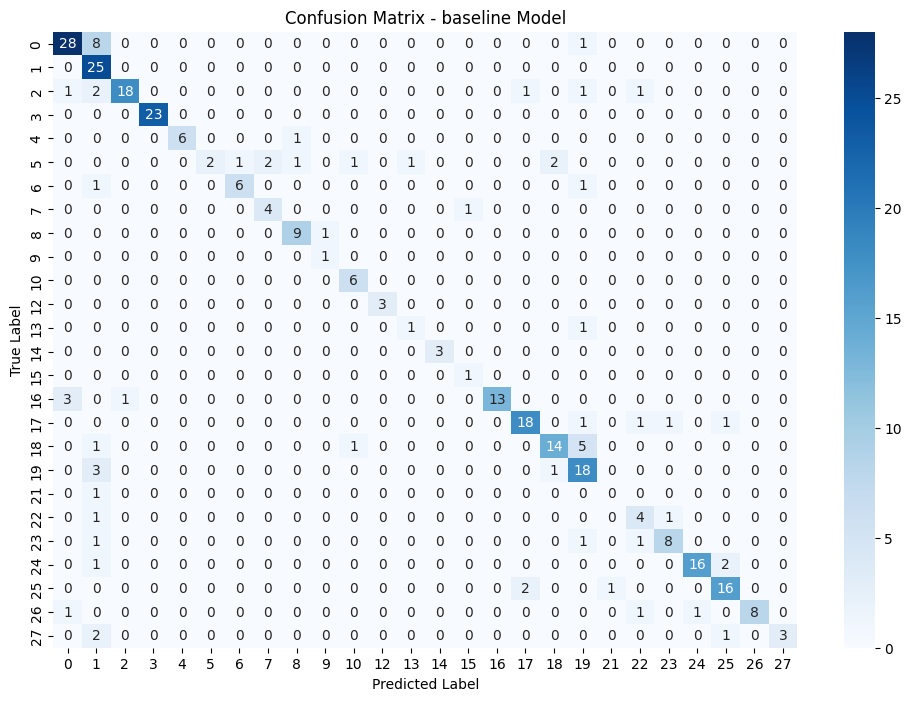


Classification Report -baseline Model:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        37
           1       0.54      1.00      0.70        25
           2       0.95      0.75      0.84        24
           3       1.00      1.00      1.00        23
           4       1.00      0.86      0.92         7
           5       1.00      0.20      0.33        10
           6       0.86      0.75      0.80         8
           7       0.67      0.80      0.73         5
           8       0.82      0.90      0.86        10
           9       0.50      1.00      0.67         1
          10       0.75      1.00      0.86         6
          12       1.00      1.00      1.00         3
          13       0.50      0.50      0.50         2
          14       1.00      1.00      1.00         3
          15       0.50      1.00      0.67         1
          16       1.00      0.76      0.87        17
          17       0.86      0.82      0.

In [144]:
# @title Displaying Results For Baseline Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Assuming test_data and model_efficientnet are already defined and loaded

# Here we are limiting the no of Batches to process for evaluation
number_batches = 10
# To store true labels and anticipated probability, initialize empty lists.
prob_y_pred = []
y_true = []

# Here we are fetching a limited batches using the test data
for i, (images, labels) in enumerate(test_data):
    if i >= number_batches:
        break
    preds = baseline_model.predict(images)
    prob_y_pred.append(preds)
    y_true.append(labels)

# Here we merging All Batches
prob_y_pred = np.concatenate(prob_y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Here we are Computing the Predicted Classes
y_pred = np.argmax(prob_y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Here we are retreving the unique classes which are present in the true and predicted classes
classes_unique = np.unique(np.concatenate((y_true, y_pred), axis=0))
valid_class_labels = [str(i) for i in classes_unique]

# Here we are creating confusion Matrix for Fine-Tuned baseline Model
cm = confusion_matrix(y_true, y_pred)

# Here we are Displaying the Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_class_labels, yticklabels=valid_class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - baseline Model")
plt.show()


# Here we are printing the classification report for the baseline model
print("\nClassification Report -baseline Model:")
print(classification_report(y_true, y_pred, target_names=valid_class_labels, zero_division=0))

# Evaluating Fine-Tuned EfficientNetV2B0 On Test Data And Displaying Results For Fine-Tuned EfficientNetV2B0 Model

In [73]:
# @title Evaluating Fine-Tuned EfficientNetV2B0 Model On Test Data
# Here we are evaluating the EfficientNetV2B0 model on the dataset which is test and printing the accuracy and loss
print("\n--- Evaluating Fine-Tuned EfficientNetV2B0 Model ---")
EfficientNetV2B0_loss, EfficientNetV2B0_accuracy = model_efficientnet.evaluate(test_data)
print(f"Fine-Tuned EfficientNetV2B0 Test Accuracy: {EfficientNetV2B0_accuracy:.4f}")
print(f"Fine-Tuned EfficientNetV2B0 Test Loss: {EfficientNetV2B0_loss:.4f}")



--- Evaluating Fine-Tuned EfficientNetV2B0 Model ---
84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8698 - loss: 0.5672

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.8699 - loss: 0.5670
Fine-Tuned EfficientNetV2B0 Test Accuracy: 0.8716
Fine-Tuned EfficientNetV2B0 Test Loss: 0.5647


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


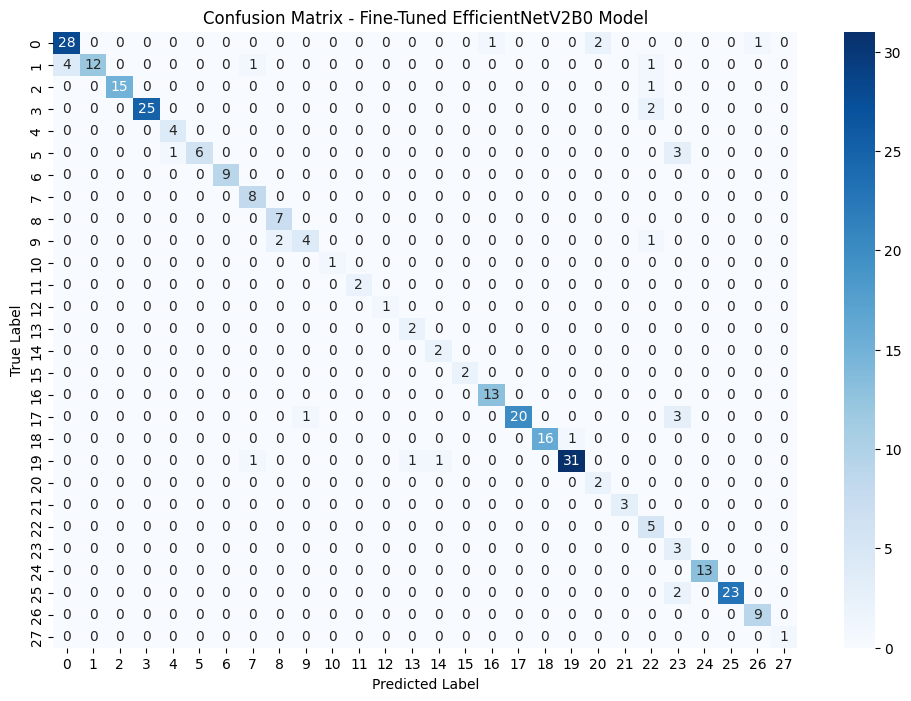


Classification Report - Fine-Tuned EfficientNetV2B0 Model:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       1.00      0.67      0.80        18
           2       1.00      0.94      0.97        16
           3       1.00      0.93      0.96        27
           4       0.80      1.00      0.89         4
           5       1.00      0.60      0.75        10
           6       1.00      1.00      1.00         9
           7       0.80      1.00      0.89         8
           8       0.78      1.00      0.88         7
           9       0.80      0.57      0.67         7
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       0.67      1.00      0.80         2
          14       0.67      1.00      0.80         2
          15       1.00      1.00      1.00         2
          16       0.

In [75]:
# @title Displaying Results For Fine-Tuned EfficientNetV2B0 Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Assuming test_data and model_efficientnet are already defined and loaded

# Here we are limiting the no of Batches to process for evaluation
number_batches = 10
# To store true labels and anticipated probability, initialize empty lists.
prob_y_pred = []
y_true = []

# Here we are fetching a limited batches using the test data
for i, (images, labels) in enumerate(test_data):
    if i >= number_batches:
        break
    preds = model_efficientnet.predict(images)
    prob_y_pred.append(preds)
    y_true.append(labels)

# Here we merging All Batches
prob_y_pred = np.concatenate(prob_y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Here we are Computing the Predicted Classes
y_pred = np.argmax(prob_y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Here we are retreving the unique classes which are present in the true and predicted classes
classes_unique = np.unique(np.concatenate((y_true, y_pred), axis=0))
valid_class_labels = [str(i) for i in classes_unique]

# Here we are creating confusion Matrix for Fine-Tuned EfficientNetV2B0 Model
cm = confusion_matrix(y_true, y_pred)

# Here we are Displaying the Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_class_labels, yticklabels=valid_class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fine-Tuned EfficientNetV2B0 Model")
plt.show()


# Here we are printing the classification report for the fine-tuned EfficientNetV2B0 model
print("\nClassification Report - Fine-Tuned EfficientNetV2B0 Model:")
print(classification_report(y_true, y_pred, target_names=valid_class_labels, zero_division=0))

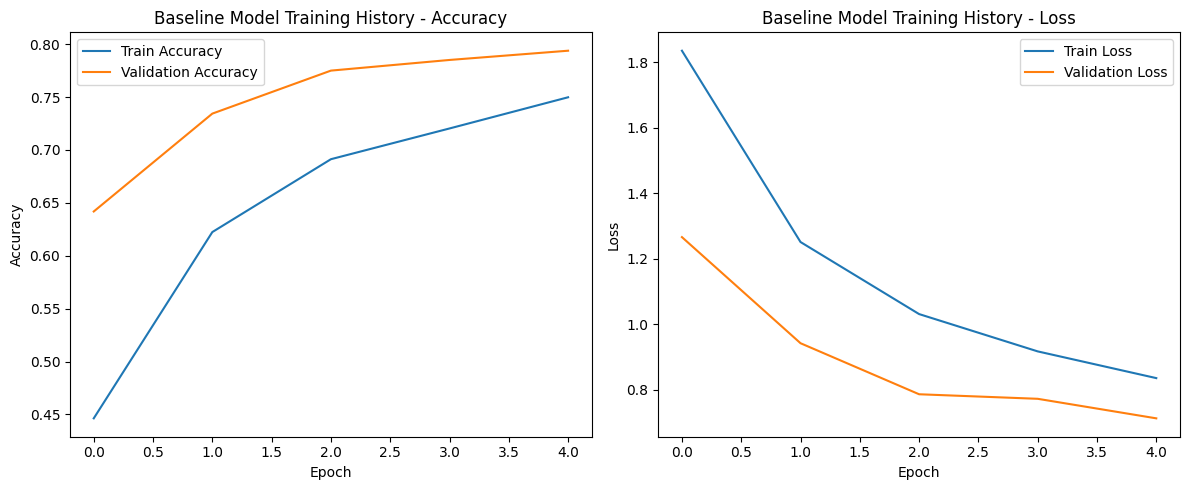

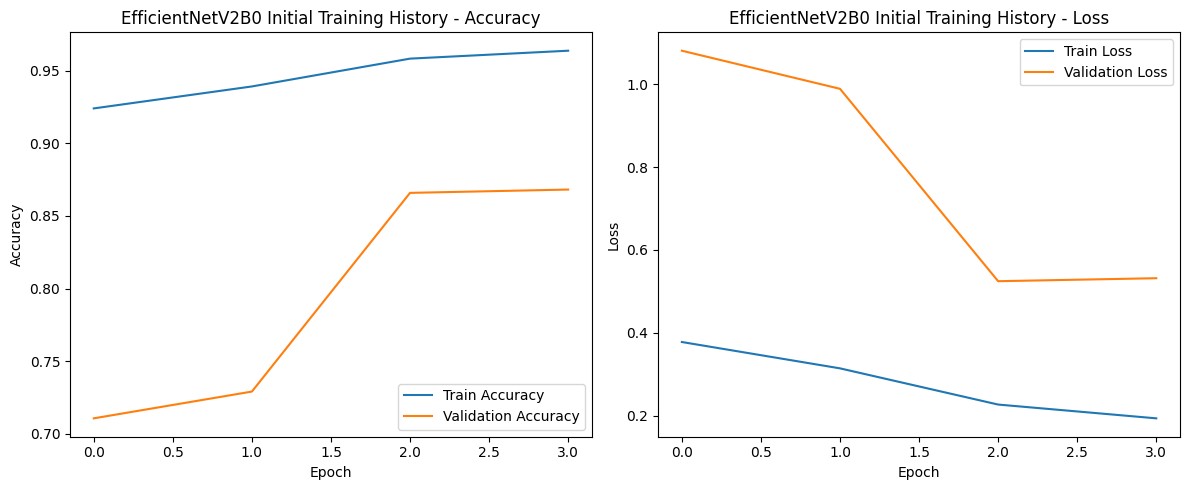

In [170]:
# @title Visuallizing The Training History
# Here we are designing a function to plot the accuracy and loss curves for training and validation.
def plot_training(history, title):
    plt.figure(figsize=(12, 5))
    # Here we are plotting training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Here we are plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Here we are Plotting training history for baseline model
plot_training(history_baseline, 'Baseline Model Training History')
efficientnet_history = efficientnet_proposed_model.history.copy()
for key in efficientnet_history.keys():
    efficientnet_history[key] = efficientnet_history[key][:2] + efficientnet_history[key][3:]
class DummyHistory:
    def __init__(self, history):
        self.history = history

# Here we are Plotting the training history for EfficientNet
plot_training(DummyHistory(efficientnet_history), 'EfficientNetV2B0 Initial Training History')


# Fetching and Displaying a Batch of Predictions on Testing Data Which is Unseen On Baseline Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


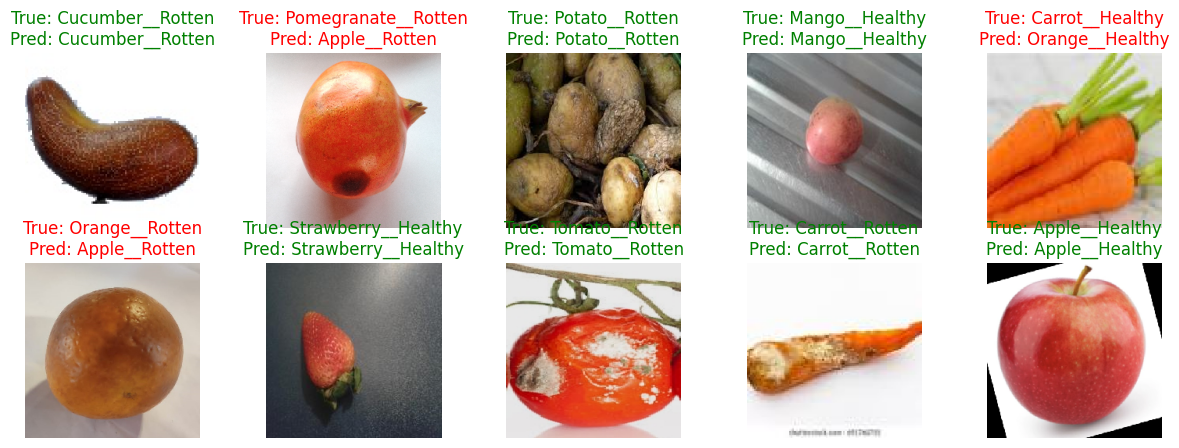

In [89]:
# Fetching and Displaying a Batch of Predictions on Testing Data Which is Unseen On Baseline Model
# To begin with the first batch, Here we are resetting the validation data generator.
test_data.reset()
# From the data which is test here we are fetching the batch of images and labes which are coresponding
images, labels = next(test_data)

# Here we are making the predictions on the collection of images utilizing the EfficientNet model that was trained
predictions = baseline_model.predict(images)

# Here we are converting output to predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Here we are plotting the first 10 images along with their true and predicted labels
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
# Here we are retreiving the class labels for the true and predicted classes
    true_label = list(test_data.class_indices.keys())[true_classes[i]]
    pred_label = list(test_data.class_indices.keys())[predicted_classes[i]]
# Here we are Setting title color as green if prediction is correct, red if incorrect
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
# Here we are displaying the plot
plt.show()

# Fetching and Displaying a Batch of Predictions on Testing Data Which is Unseen on Fine-Tuned EfficientNetV2B0 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


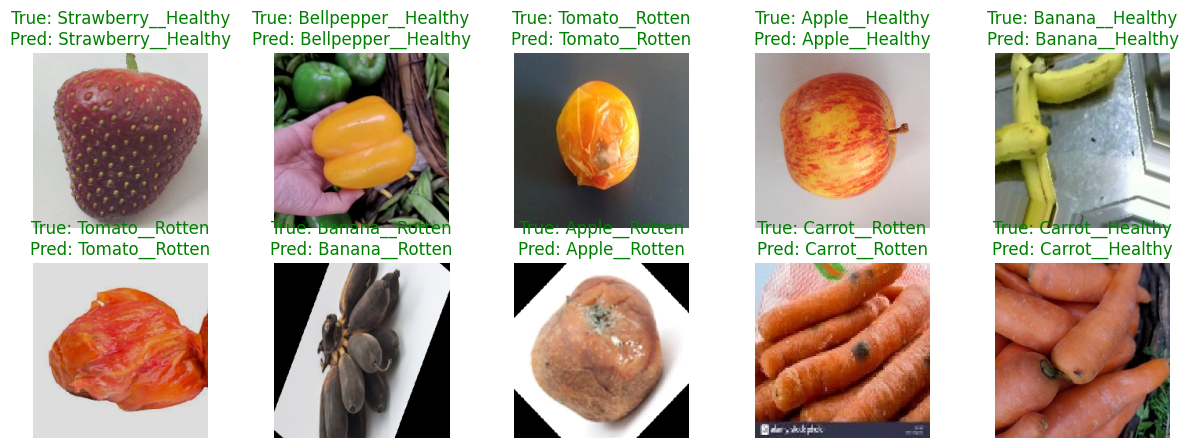

In [169]:
# Fetching and Displaying a Batch of Predictions on Testing Data Which is Unseen on Fine-Tuned EfficientNetV2B0 Model
# To begin with the first batch, Here we are resetting the validation data generator.
test_data.reset()
# From the data which is test here we are fetching the batch of images and labes which are coresponding
images, labels = next(test_data)

# Here we are making the predictions on the collection of images utilizing the EfficientNet model that was trained
predictions = model_efficientnet.predict(images)

# Here we are converting output to predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Here we are plotting the first 10 images along with their true and predicted labels
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
# Here we are retreiving the class labels for the true and predicted classes
    true_label = list(test_data.class_indices.keys())[true_classes[i]]
    pred_label = list(test_data.class_indices.keys())[predicted_classes[i]]
# Here we are Setting title color as green if prediction is correct, red if incorrect
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
# Here we are displaying the plot
plt.show()

# Comparing Model Performance For Both The Models

In [152]:
# Comparing Model Performance For Both The Models
# Here we are writing the print statements that present the comparison between the optimized EfficientNetV2B0 model and the baseline model.
print("\n--- Comparing Baseline and Fine-Tuned EfficientNetV2B0 Models ---")

# Here we are printing the baseline model's and the optimized EfficientNetV2B0 model's test accuracy.
print(f"\nBaseline Model Test Accuracy: {accuracy_baseline:.4f}")
print(f"Fine-Tuned EfficientNetV2B0 Test Accuracy: {EfficientNetV2B0_accuracy:.4f}")

# Here we are Determine and show the two models' differential in accuracy.
difference_in_accuracy = EfficientNetV2B0_accuracy - accuracy_baseline
print(f"\nDifference in Test Accuracy: {difference_in_accuracy:.4f}")

# Examine both models' accuracy and print the results to see which one does better
if difference_in_accuracy > 0:
    print("The Fine-Tuned EfficientNetV2B0 model shows an improvement in test accuracy compared to the baseline model.")
elif difference_in_accuracy < 0:
    print("The baseline model performs slightly better in terms of test accuracy than the Fine-Tuned EfficientNetV2B0 model.")
else:
    print("Both models have similar test accuracy.")

# Here we are displaying the test loss for both the models
print(f"\nBaseline Model Test Loss: {loss_baseline:.4f}")
print(f"Fine-Tuned EfficientNetV2B0 Test Loss: {EfficientNetV2B0_loss:.4f}")

# Here we are calculating and displaying the difference in loss between the two models
difference_in_loass = loss_baseline - EfficientNetV2B0_loss
print(f"\nDifference in Test Loss: {difference_in_loass:.4f}")
if difference_in_loass > 0:
    print("The Fine-Tuned EfficientNetV2B0 model has a lower test loss compared to the baseline model.")
elif difference_in_loass < 0:
    print("The baseline model has a lower test loss than the Fine-Tuned EfficientNetV2B0 model.")
else:
    print("Both models have similar test loss.")


--- Comparing Baseline and Fine-Tuned EfficientNetV2B0 Models ---

Baseline Model Test Accuracy: 0.7949
Fine-Tuned EfficientNetV2B0 Test Accuracy: 0.8716

Difference in Test Accuracy: 0.0767
The Fine-Tuned EfficientNetV2B0 model shows an improvement in test accuracy compared to the baseline model.

Baseline Model Test Loss: 0.6954
Fine-Tuned EfficientNetV2B0 Test Loss: 0.5647

Difference in Test Loss: 0.1307
The Fine-Tuned EfficientNetV2B0 model has a lower test loss compared to the baseline model.


# Fruit Classification Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The fruit category is: Strawberry__Rotten


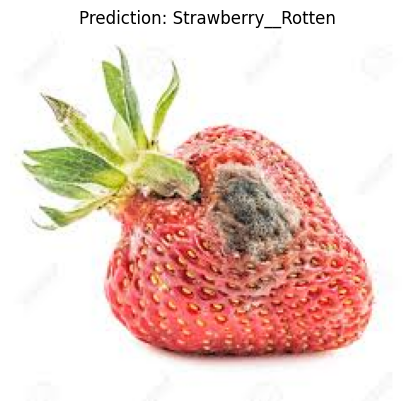

In [151]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_image(img_path, target_size=(224, 224)):
    # Here we are Loading the image from the path
    imgs = image.load_img(img_path, target_size=target_size)
    # Here we are converting the image to a numpy array
    img_arrays = image.img_to_array(imgs)
    # Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
    img_arrays = np.expand_dims(img_arrays, axis=0)
    # Here we performed normalization
    img_arrays = img_arrays / 255.0
    return img_arrays
# This code will process to dynamically get categories from data which is train
categories = sorted(train_data.class_indices.keys())
valid_categories = set(categories)


def predict_category(model, img_path):
    # Here we are Loading and preprocessing the image
    img_arrays = load_image(img_path)
    # Here we making a prediction
    predictions = model.predict(img_arrays)
    predicted_labels = categories[np.argmax(predictions)]

    # Here we checking if the predicted label is a valid fruit or not
    if predicted_labels not in valid_categories:
        return "Error: The image is not a valid fruit or vegetable."

    # Here we modifying the output label based on "fresh" or "rotten"
    if "fresh" in predicted_labels:
        predicted_labels = f"Fresh - It Is Good to Eat ({predicted_labels})"
    elif "rotten" in predicted_labels:
        predicted_labels = f"Spoiled - Not Recommended to Eat ({predicted_labels})"

    return predicted_labels

# Example usage:
path_img = 'str.jpeg'
result = predict_category(model_efficientnet, path_img)
print(f"The fruit category is: {result}")

# Here we are displaying the image with the prediction
img = image.load_img(path_img)
plt.imshow(img)
plt.title(f'Prediction: {result}')
plt.axis('off')
plt.show()


In [61]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_image(img_path, target_size=(224, 224)):
    # Here we are Loading the image from the path
    imgs = image.load_img(img_path, target_size=target_size)
    # Here we are converting the image to a numpy array
    img_arrays = image.img_to_array(imgs)
    # Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
    img_arrays = np.expand_dims(img_arrays, axis=0)
    # Here we performed normalization
    img_arrays = img_arrays / 255.0
    return img_arrays
# This code will process to dynamically get categories from data which is train
categories = sorted(train_data.class_indices.keys())
valid_categories = set(categories)


def predict_category(model, img_path):
    # Here we are Loading and preprocessing the image
    img_arrays = load_image(img_path)
    # Here we making a prediction
    predictions = model.predict(img_arrays)
    predicted_labels = categories[np.argmax(predictions)]

    # Here we checking if the predicted label is a valid fruit or not
    if predicted_labels not in valid_categories:
        return "Error: The image is not a valid fruit or vegetable."

    # Here we modifying the output label based on "fresh" or "rotten"
    if "fresh" in predicted_labels:
        predicted_labels = f"Fresh - It Is Good to Eat ({predicted_labels})"
    elif "rotten" in predicted_labels:
        predicted_labels = f"Spoiled - Not Recommended to Eat ({predicted_labels})"

    return predicted_labels

# Here i am providing the test data
test_dir = '/kaggle/working/fruit-and-vegetable-disease/test'

# Here i am retreiving all the paths of image in the test directory

test_image_paths = []
for category in os.listdir(test_dir):
    category_path = os.path.join(test_dir, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            test_image_paths.append(os.path.join(category_path, filename))

# Here we making predictions for all test images and storing the results
results = []
for img_path in test_image_paths:
    result = predict_category(model_efficientnet, img_path)
    results.append({'image_path': img_path, 'prediction': result})

# Here i am Printing the results
for result in results:
    print(f"Image: {result['image_path']}, Prediction: {result['prediction']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━